In [1]:
from torch import nn 
import torch
import kornia.geometry.subpix as k
from lib.dataloader import RoofDataSet, Transforms, show_centroids
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from lib.modeltraining import train_model
import matplotlib.pyplot as plt

In [2]:
full_path = "/Users/alex_christlieb/Downloads/Dataset/data_2022-11-01/meta_data.hdf"
raw_data = RoofDataSet(full_path, transform=Transforms(new_size = (224,224), transform_list=["resize", "to_tensor"]), mode = "constant")

-------------------- Initializing dataset --------------------
--> Metadata read
--> Num_panels computed
--> Samples with many panels dropped
--> Padding samples
--> Dataset ready


In [4]:
# split the dataset into training, validation and test sets
# Create testset
len_train_set = int(0.02*len(raw_data))
len_test_set = len(raw_data) - len_train_set

train_dataset , test_dataset  = torch.utils.data.random_split(raw_data, [len_train_set, len_test_set],  generator=torch.Generator().manual_seed(1))

len_valid_set = int(0.2*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set],  generator=torch.Generator().manual_seed(1))

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))


# shuffle and batch the datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
test_trained = DataLoader(train_dataset, batch_size=1, shuffle=True)

The length of Train set is 32
The length of Valid set is 7
The length of Test set is 1936


In [15]:
class FCN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.layers(x)

class Resnet18(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model_name='resnet18'
        resnet = models.resnet50(pretrained=True)
        resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        modules = list(resnet.children())[:-2] #Removing the last two layers (up until before the Pooling)
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
from torchsummary import summary
resnet = models.resnet5(pretrained=False)
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
summary(resnet, input_size = (3,224,224))
# resnet.layer1.add_module()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           4,096
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 256, 112, 112]          16,384
      BatchNorm2d-12        [-1, 256, 112, 112]             512
           Conv2d-13        [-1, 256, 112, 112]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [54]:
summary(resnet, input_size= (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          36,864
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
       BasicBlock-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,864
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             ReLU-14         [-1, 64, 1

In [18]:
class CoordRegressionNetwork(nn.Module):
    def __init__(self, n_locations):
        super().__init__()
        self.fcn = Resnet18()
        self.hm_conv = nn.Conv2d(2048, n_locations, kernel_size=1, bias=False)

    def forward(self, images):
        # 1. Run the images through our FCN
        fcn_out = self.fcn(images)
        # print(fcn_out.shape)
        # 2. Use a 1x1 conv to get one unnormalized heatmap per location
        unnormalized_heatmaps = self.hm_conv(fcn_out)
        # print(fcn_out.shape)
        # 3. Normalize the heatmaps
        heatmaps = k.dsnt.spatial_softmax2d(unnormalized_heatmaps)
        # 4. Calculate the coordinates
        coords = k.dsnt.spatial_expectation2d(heatmaps, normalized_coordinates=False)

        return coords, heatmaps

In [12]:
from torch import optim
import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
from PIL import Image

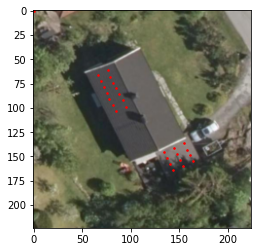

In [13]:
it = iter(test_loader)
img, centroid = next(it)
show_centroids(img[0], centroid[0], tensor=True)
# img.shape


In [7]:
model = CoordRegressionNetwork(n_locations = 27)

# network = Resnet18_DSNT(num_classes=raw_data.max_num_panels)
# network = Resnet18(num_classes=raw_data.max_num_panels*2)
criterion = torch.nn.MSELoss()
# SGD diverges on our model
# optimizer = optim.SGD(network.parameters(), lr=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

loss_min = 0.001
num_epochs = 1

# Train model
model = train_model(model, criterion, optimizer, num_epochs, train_loader, valid_loader)


NameError: name 'optim' is not defined

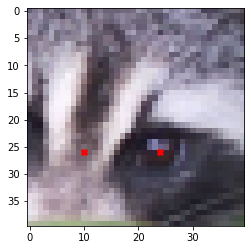

In [10]:
raccoon_face = np.array(Image.fromarray(scipy.misc.face()[200:400, 600:800, :]).resize(size=(40,40)))
eye_x, eye_y = 24, 26
c1, c2 = 10,26

plt.imshow(raccoon_face)
plt.scatter([eye_x], [eye_y], color='red', marker='X')
plt.scatter([c1], [c2], color='red', marker='X')
plt.show()

In [12]:
raccoon_face_tensor = torch.from_numpy(raccoon_face).permute(2, 0, 1).float()
input_tensor = raccoon_face_tensor.unsqueeze(0)
# input_var = input_tensor.cuda()

target_tensor = torch.Tensor([[[eye_x, eye_y], [c1,c2]]])
# target_tensor = (eye_coords_tensor * 2 + 1) / torch.Tensor([40,40]) - 1
# target_var = target_tensor.cuda()

# print('Target: {:0.4f}, {:0.4f}'.format(*list(target_tensor.squeeze())))

In [19]:
model = CoordRegressionNetwork(n_locations=27)

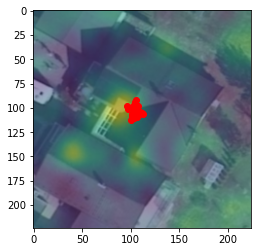

In [24]:
it = iter(test_loader)
img, centroid = next(it)

coords, heatmaps = model(img)
upscale = torch.nn.Upsample(scale_factor=16, mode='bicubic', recompute_scale_factor=True) #Upscaling
heatmaps = upscale(heatmaps)
coords = coords*16
# print('Initial prediction: {:0.4f}, {:0.4f}'.format(*list(coords[0, 0])))
# print('Initial prediction: {:0.4f}, {:0.4f}'.format(*list(coords[0, 1])))

# plt.scatter(coords)
# plt.scatter()

plt.scatter(coords.squeeze().detach()[:,1], coords.squeeze().detach()[:,0], c = 'r')
# plt.scatter(centroid.squeeze().detach()[:,1], centroid.squeeze().detach()[:,0], c = 'b')
# print(coords)
plt.imshow(img[0].permute(1,2,0))
plt.imshow(heatmaps[0, 0].detach().cpu().numpy(), alpha = 0.5)

In [28]:
import kornia.losses as loss

In [26]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

In [27]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=2.5e-4)

step = 1
loss_train = 0

for i in range(400):
    # Forward pass
    coords, heatmaps = model(img)

    # Per-location euclidean losses
    L = torch.nn.functional.mse_loss(coords, centroid/32)
    # Per-location regularization losses
    # reg_losses = dsntnn.js_reg_losses(heatmaps, target_var, sigma_t=1.0)
    # Combine losses into an overall loss
    # loss = dsntnn.average_loss(euc_losses + reg_losses)

    # Calculate gradients
    optimizer.zero_grad()
    L.backward()

    loss_train += L.item()
    running_loss = loss_train/step

    # Update model parameters with RMSprop
    optimizer.step()
    print_overwrite(step, 400, running_loss, 'train')
    step = step + 1
    

# Predictions after training
# print('Predicted coords: {:0.4f}, {:0.4f}'.format(*list(coords[0, 0])))
plt.imshow(heatmaps[0, 0].detach().cpu().numpy())
plt.show()

Train Steps: 83/400  Loss: 1.5880 

KeyboardInterrupt: 

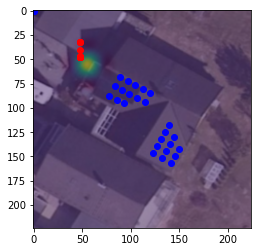

In [28]:
coords, heatmaps = model(img)

upscale = torch.nn.Upsample(scale_factor=16, mode='bicubic', recompute_scale_factor=True) #Upscaling
heatmaps = upscale(heatmaps)
coords = coords*16

plt.scatter(coords.squeeze().detach()[:,1], coords.squeeze().detach()[:,0], c = 'r')
plt.scatter(centroid.squeeze().detach()[:,1], centroid.squeeze().detach()[:,0], c = 'b')
# print(coords)
plt.imshow(img[0].permute(1,2,0))
plt.imshow(heatmaps[0, 0].detach().cpu().numpy(), alpha = 0.5)

Train Steps: 356/356  Loss: 0.4233 Predicted coords: 3.6971, 4.1067


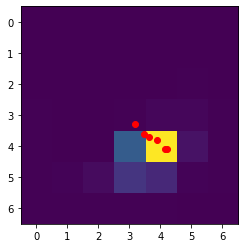

In [13]:
optimizer = optim.RMSprop(model.parameters(), lr=2.5e-4)

for epoch in range(2):
    step = 1
    loss_train = 0

    for image, centroid in train_loader:
    # Forward pass
        coords, heatmaps = model(image)
        # Per-location euclidean losses
        L = torch.nn.functional.mse_loss(coords, centroid/32)
        # Per-location regularization losses
        # reg_losses = dsntnn.js_reg_losses(heatmaps, target_tensor, sigma_t=1.0)
        # Combine losses into an overall loss
        # loss = dsntnn.average_loss(euc_losses + reg_losses)

        # Calculate gradients
        optimizer.zero_grad()
        L.backward()

        # Update model parameters with RMSprop
        loss_train += L.item()

        running_loss = loss_train/step
        optimizer.step()
        print_overwrite(step, len(train_loader), running_loss, 'train')
        step = step + 1

# Predictions after training
print('Predicted coords: {:0.4f}, {:0.4f}'.format(*list(coords[0, 0])))
plt.imshow(heatmaps[0, 0].detach().cpu().numpy())
# plt.scatter(coords)
plt.scatter(coords.squeeze().detach()[:,1], coords.squeeze().detach()[:,0], c = 'r')

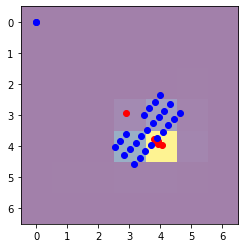

In [30]:
# it = iter(test_loader)
img, centroid = next(it)
pred, heatmap = model(image)

upscale = torch.nn.Upsample(scale_factor=32, mode='bilinear', recompute_scale_factor=True) #Upscaling
# heatmaps = upscale(heatmap)
# pred = pred*32
centroid = centroid/32

plt.scatter(pred.squeeze().detach()[:,1], pred.squeeze().detach()[:,0], c = 'r')
plt.scatter(centroid.squeeze().detach()[:,1], centroid.squeeze().detach()[:,0], c = 'b')
# print(coords)
# plt.imshow(img[0].permute(1,2,0))
plt.imshow(heatmap[0, 0].detach().cpu().numpy(), alpha = 0.5)

In [22]:
i = image[0]
i = i.permute(1,2,0)
i.shape

torch.Size([40, 40, 3])

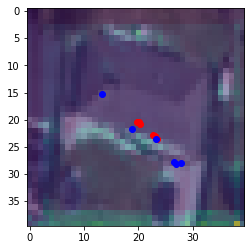

In [29]:
plt.scatter(coords.squeeze().detach()[:,1], coords.squeeze().detach()[:,0], c = 'r')
plt.scatter(centroid.squeeze().detach()[:,1], centroid.squeeze().detach()[:,0], c = 'b')
plt.imshow(i)
plt.imshow(heatmaps[0, 0].detach().cpu().numpy(),  alpha = 0.5)


In [23]:
print(coords)

tensor([[[24.0011, 25.9852],
         [ 9.8428, 26.3385]]], grad_fn=<ViewBackward0>)


In [45]:
input_tensor.shape

torch.Size([1, 3, 40, 40])

In [33]:
from torchsummary import summary 
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,